In [1]:
#!/usr/bin/env python3
"""
Trolley Problem Analysis - Prior Predictive Only
================================================
Using Our bayes_ordinal Package
================================================
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Import our bayes_ordinal package
import sys
sys.path.append('..')
import bayes_ordinal as bo

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("TROLLEY PROBLEM ANALYSIS - PRIOR PREDICTIVE ONLY")
print("=" * 60)
print("Using Our bayes_ordinal Package")
print("=" * 60)

TROLLEY PROBLEM ANALYSIS - PRIOR PREDICTIVE ONLY
Using Our bayes_ordinal Package


In [2]:
print("1. Loading and Cleaning Data...")
print("=" * 50)

# Load the trolley dataset with correct separator
data = pd.read_csv("../Dataset/Trolley.csv", sep=';')
print(f" Raw dataset shape: {data.shape}")

# Clean the data
data = data.dropna()
print(f" Cleaned dataset shape: {data.shape}")

# Check response variable
print(f" Response range: {data['response'].min()} to {data['response'].max()}")
print(f" Number of categories: {data['response'].nunique()}")
print(f" Features: {['action', 'intention', 'contact']}")

# Display response distribution
print("\nResponse distribution:")
print(data['response'].value_counts().sort_index())

# Prepare features
feature_cols = ['action', 'intention', 'contact']
X = data[feature_cols].values
y = data['response'].values

# Convert to 0-based indexing for PyMC
y_zero_based = y - 1

1. Loading and Cleaning Data...
 Raw dataset shape: (9930, 12)
 Cleaned dataset shape: (9930, 12)
 Response range: 1 to 7
 Number of categories: 7
 Features: ['action', 'intention', 'contact']

Response distribution:
response
1    1274
2     909
3    1071
4    2323
5    1462
6    1445
7    1446
Name: count, dtype: int64


In [3]:
print("\n2. Data Validation...")
print("=" * 50)

# Validate data using our package
validation_results = bo.validate_ordinal_data(y_zero_based, X)
print(" Data validation completed")


2. Data Validation...
 Data validation completed


In [4]:
print("\n3. Data Exploration...")
print("=" * 50)

# Feature summary
print("Feature Summary:")
for i, col in enumerate(feature_cols):
    print(f"  {col}: mean={X[:, i].mean():.3f}, std={X[:, i].std():.3f}")

# Correlation matrix
corr_matrix = pd.DataFrame(X, columns=feature_cols).corr()
print(f"\nFeature Correlation Matrix:")
print(corr_matrix.round(3))

print(" Data exploration completed")


3. Data Exploration...
Feature Summary:
  action: mean=0.433, std=0.496
  intention: mean=0.467, std=0.499
  contact: mean=0.200, std=0.400

Feature Correlation Matrix:
           action  intention  contact
action      1.000     -0.144   -0.437
intention  -0.144      1.000    0.033
contact    -0.437      0.033    1.000
 Data exploration completed


In [5]:
print("\n4. Prior Specification...")
print("=" * 50)

# Define priors for the cumulative model
priors = {
    "beta": [0, 0.5],       # [mu, sigma] for beta
    "sigma": 1,           #  Normal(0, 1) for cutpoints
    "mu": np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]),      # mu=0 for all cutpoints
    "constrained_uniform": False
}

print("Prior specifications (matching OC exactly):")
print(f"  beta: {priors['beta']} (coefficient mean=0, std=0.5 - like OC)")
print(f"  sigma: {priors['sigma']} (cutpoint prior std=1.0 - like OC)")
print(f"  mu: {priors['mu']} (cutpoint means=0 for all - like OC)")


4. Prior Specification...
Prior specifications (matching OC exactly):
  beta: [0, 0.5] (coefficient mean=0, std=0.5 - like OC)
  sigma: 1 (cutpoint prior std=1.0 - like OC)
  mu: [-2.5 -1.5 -0.5  0.5  1.5  2.5] (cutpoint means=0 for all - like OC)



5. Building Model (Using Our Package)...
Building logit model...
 Logit model built successfully

Model Structure:
Model Structure (PyMC Graphviz):


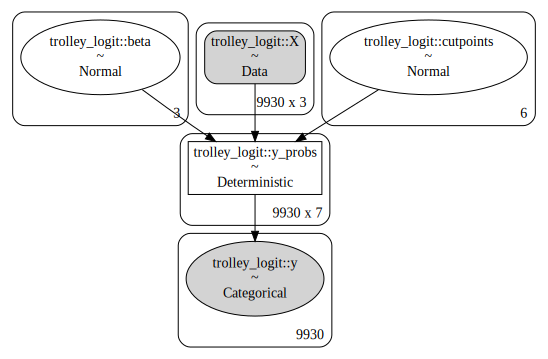

 Graphviz visualization displayed successfully!


In [6]:
print("\n5. Building Model (Using Our Package)...")
print("=" * 50)

print("Building logit model...")

# Build the logit model using our package
logit_model = bo.cumulative_model(
    y=y_zero_based,
    X=X,
    K=len(np.unique(y_zero_based)),  # Number of unique categories
    link="logit",
    priors=priors,
    model_name="trolley_logit",
    prior_type="fixed_sigma",
    feature_names=feature_cols
)

print(" Logit model built successfully")

# Display model structure
print("\nModel Structure:")
print("Model Structure (PyMC Graphviz):")

# Import pymc and create the model structure
import pymc as pm

# Create the graphviz visualization
model_graph = pm.model_to_graphviz(logit_model)

display(model_graph)
print(" Graphviz visualization displayed successfully!")

 Running prior predictive check for model: trolley_logit
 Drawing 1000 samples from prior predictive distribution


Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


 Successfully sampled 1000 prior predictive draws


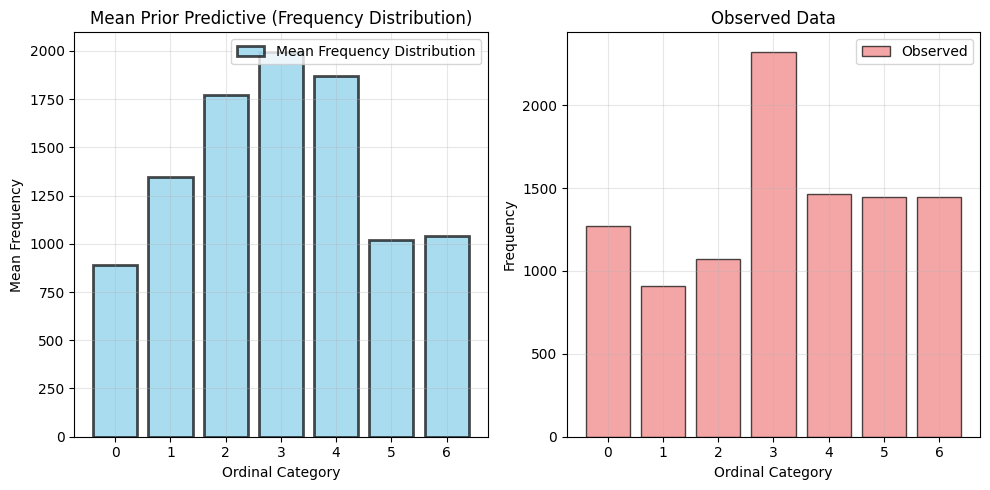

 Prior predictive plots generated successfully
 Prior predictive check completed successfully!
 Results stored in InferenceData object


In [7]:
# Run prior predictive checks
prior_pred_logit = bo.run_prior_predictive(
    model=logit_model,
    draws=1000,
    plot=True,
    y_obs=y_zero_based,  # This is optional - only for comparison plots
    model_name="trolley_logit",
)

In [8]:
print("\n8. Model Fitting...")
print("=" * 50)

print("Fitting logit model...")

# Fit the model using our package - now with progress tracking!
idata_logit = bo.fit_ordinal_model(
    model=logit_model,
    chains=4,
    draws=1500,
    tune=1000,
    random_seed=42
    # progressbar=True and compute_convergence_checks=True are now default!
)

print(" Logit model fitting completed")
print(f" InferenceData shape: {idata_logit.posterior['trolley_logit::beta'].shape}")


8. Model Fitting...
Fitting logit model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trolley_logit::beta, trolley_logit::cutpoints]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 387 seconds.
Sampling: [trolley_logit::y]


 Adding posterior predictive samples...


 Posterior predictive samples added
 Logit model fitting completed
 InferenceData shape: (4, 1500, 3)



9. Model Diagnostics...
Running comprehensive diagnostics...
 Log likelihood available for LOO/WAIC calculations
  Max R-hat: 1.000
 Diagnostic summary completed
  Model: trolley_logit
  Summary shape: (69519, 12)
  R-hat column exists: True
  R-hat values: [1. 1. 1. ... 1. 1. 1.]
  Converged: True
Creating diagnostic plots...
 Creating energy plot...


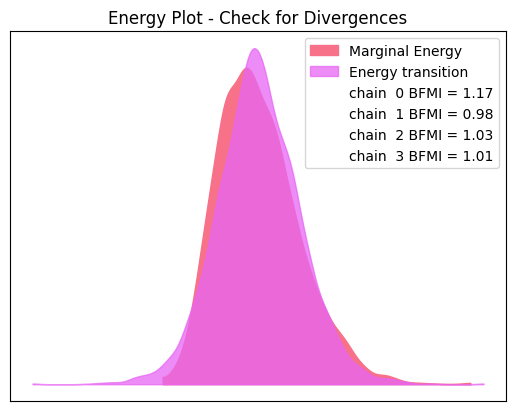

 Creating trace plots...


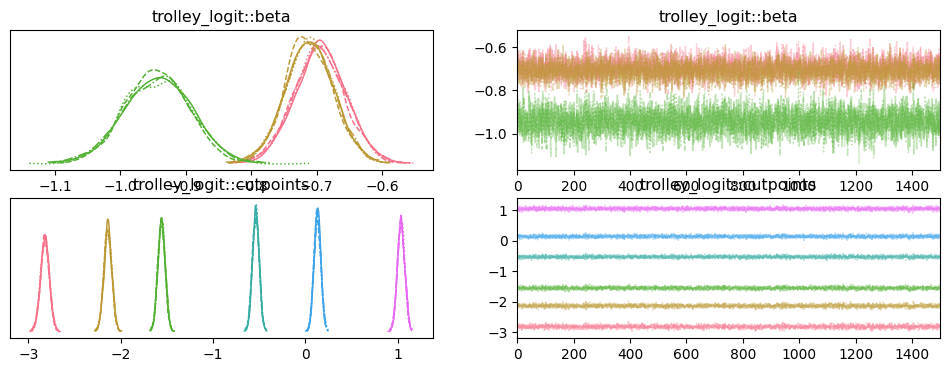

 Creating rank plots...


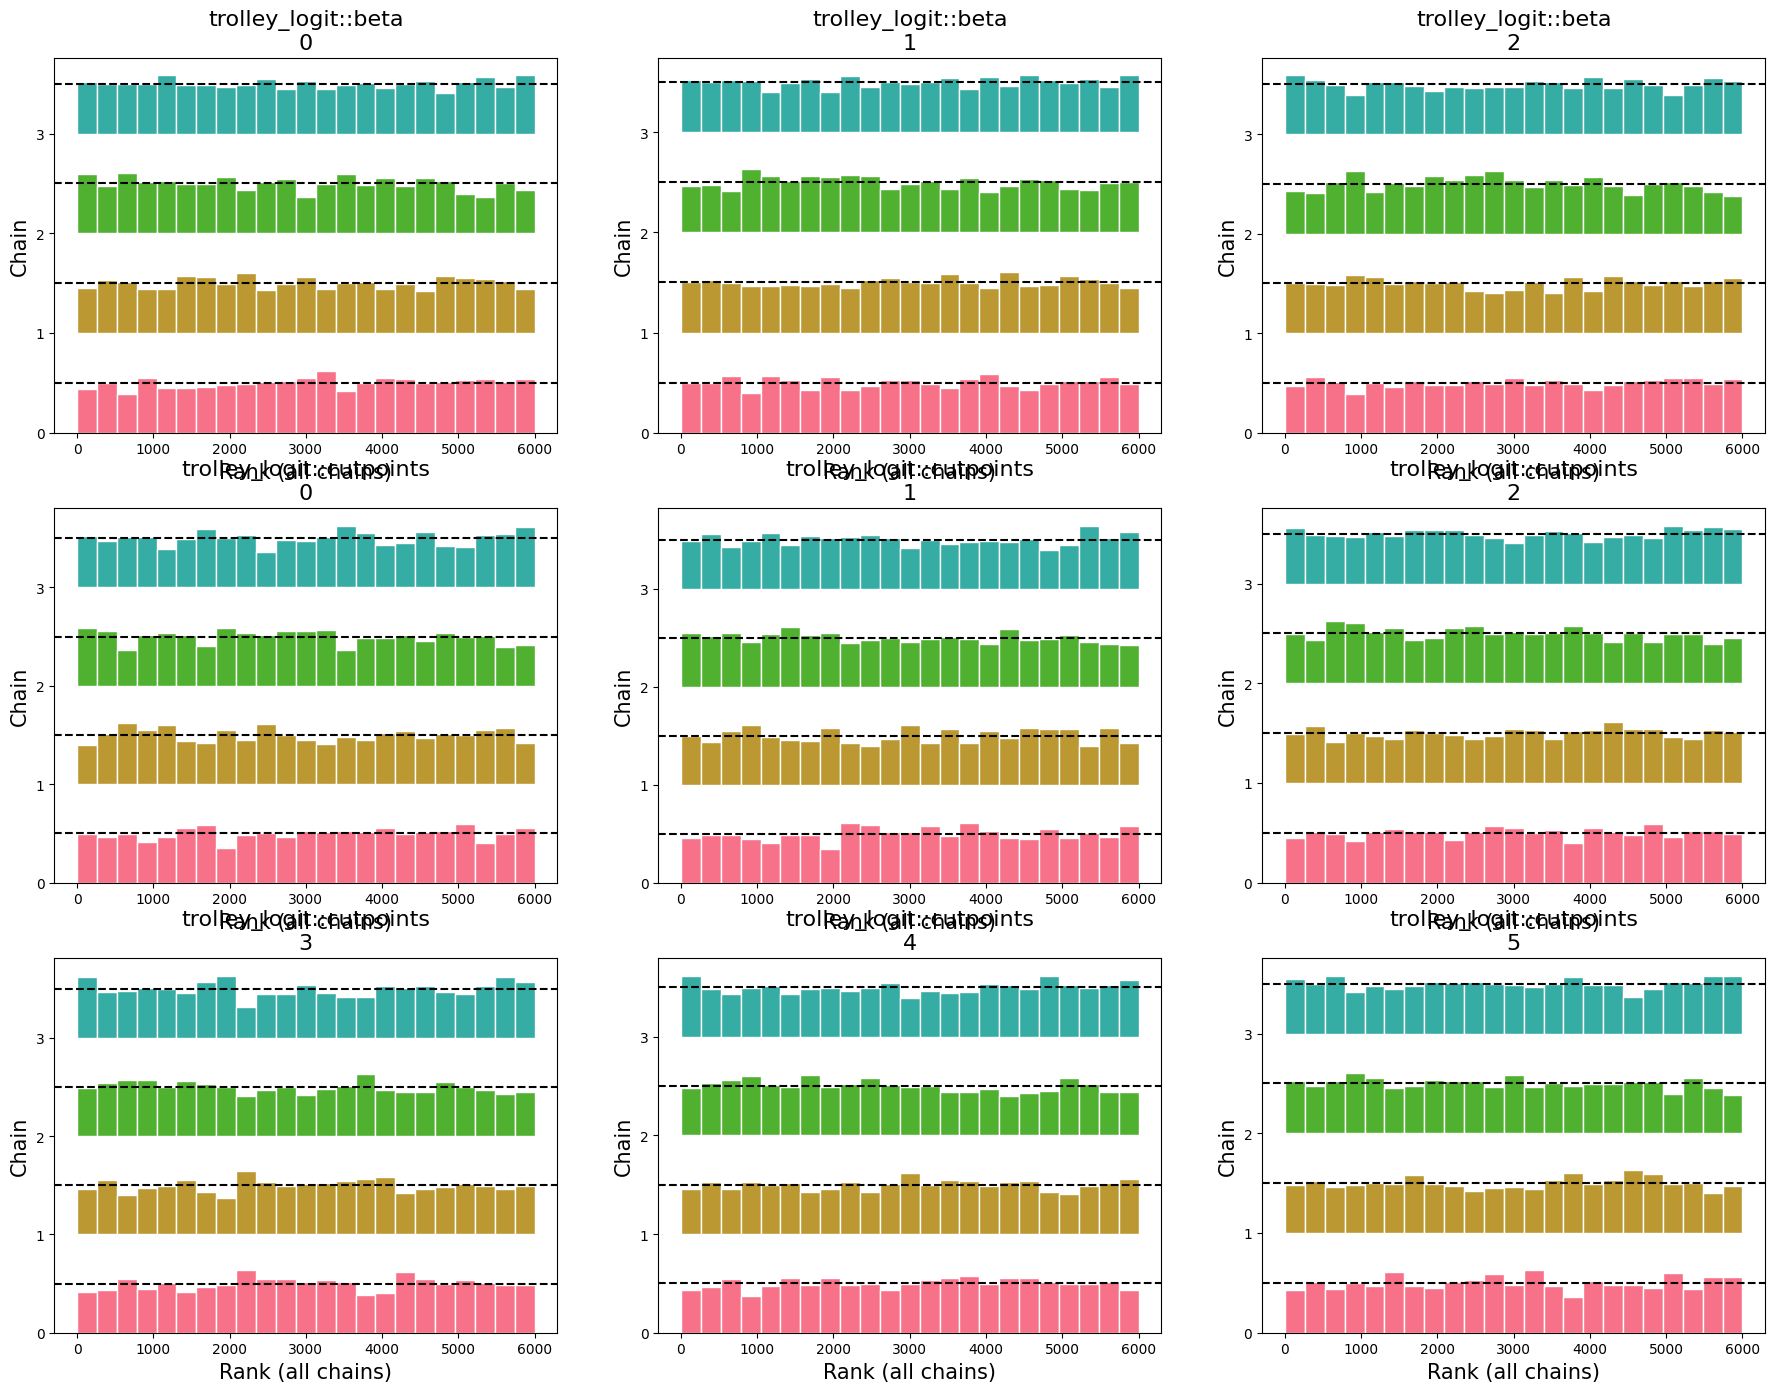

 Creating autocorrelation plots...


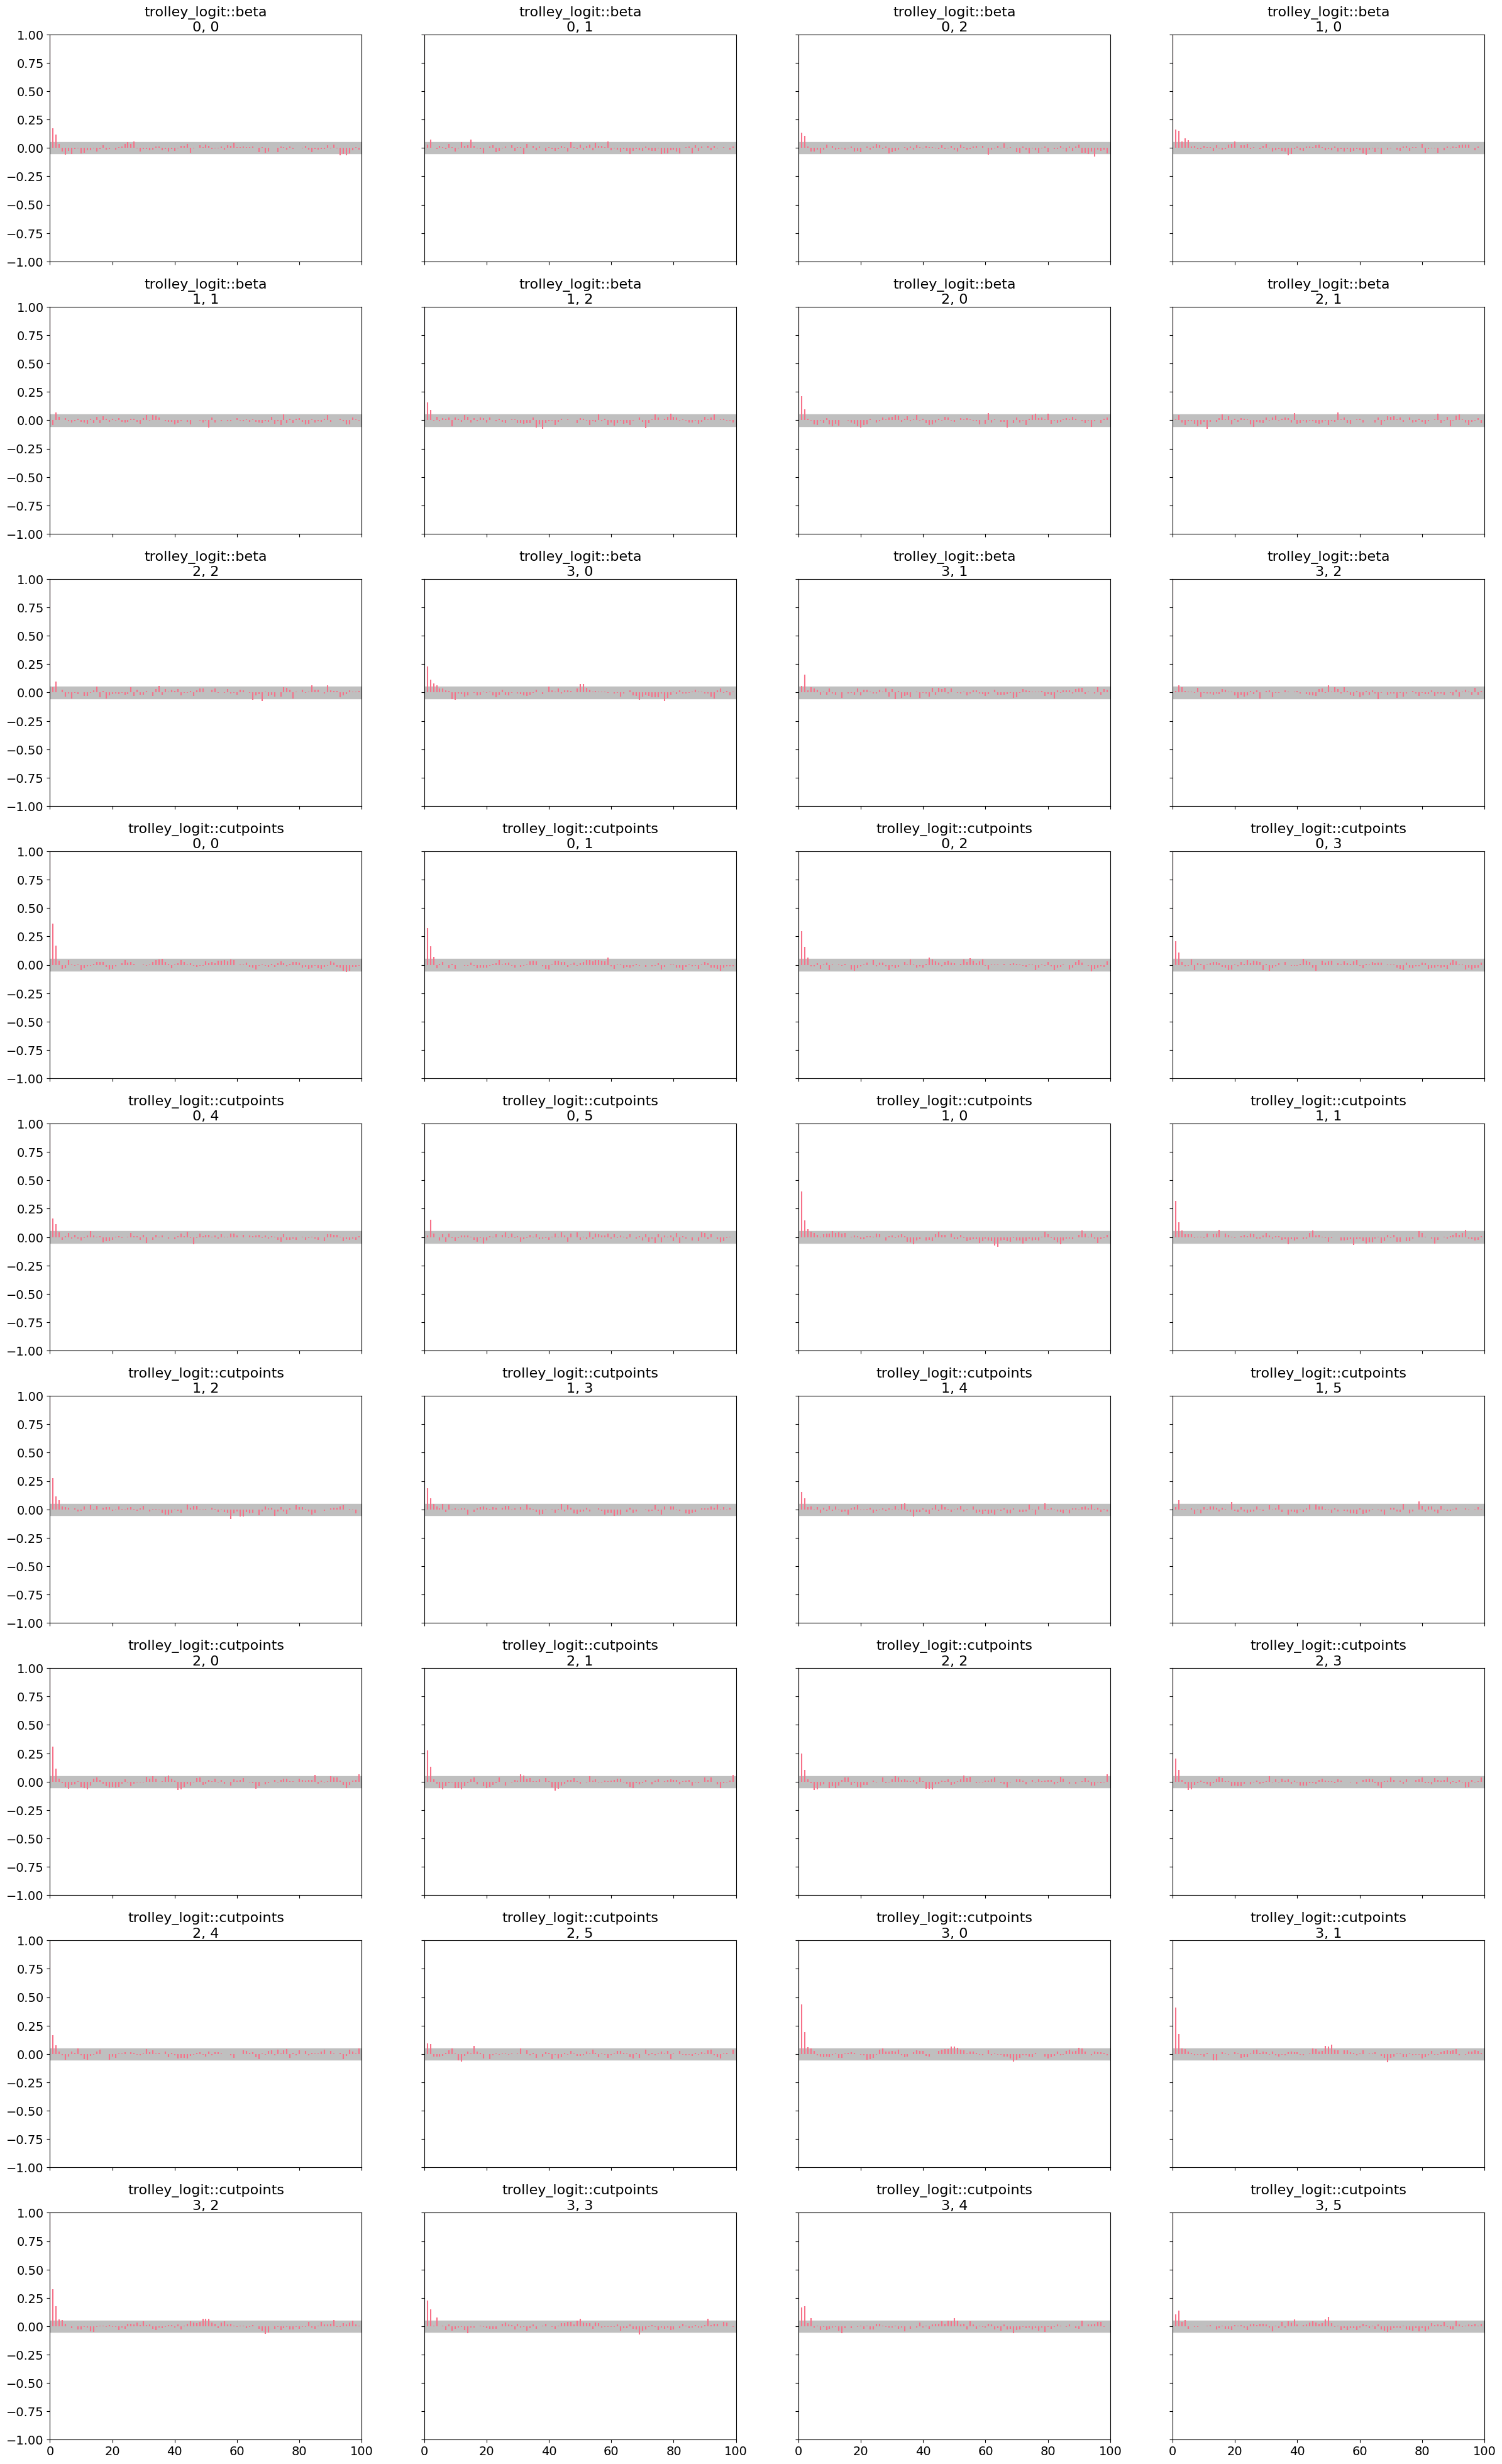

 Diagnostic plots completed
 Diagnostic plots completed

 Diagnostics completed!
 Model converged: True
 Max R-hat: 1.000
 Min ESS: 2759.0
 Divergences: 0

Creating detailed model summary...
 Log likelihood available for LOO/WAIC calculations
 Model summary completed!
 Sampling info: {'n_chains': 4, 'n_draws': 1500, 'n_parameters': 3, 'sampling_time': None}
 Parameters analyzed: ['trolley_logit::beta', 'trolley_logit::cutpoints', 'trolley_logit::y_probs']

 Parameter Summary (like PyMCOrdinal):
----------------------------------------
                              mean     sd  hdi_3%  hdi_97%  ess_bulk  r_hat
trolley_logit::beta[0]      -0.695  0.040  -0.772   -0.622  3352.824  1.001
trolley_logit::beta[1]      -0.711  0.037  -0.776   -0.638  4837.582  1.000
trolley_logit::beta[2]      -0.944  0.051  -1.037   -0.847  4322.211  1.001
trolley_logit::cutpoints[0] -2.820  0.047  -2.907   -2.730  2759.030  1.001
trolley_logit::cutpoints[1] -2.139  0.042  -2.221   -2.063  2904.684  1.001
tro

In [ ]:
print("\n9. Model Diagnostics...")
print("=" * 50)

# Import diagnostics functions
from bayes_ordinal.workflow.diagnostics import (
    run_comprehensive_diagnostics,
    create_model_summary,
    plot_diagnostics
)

print("Running comprehensive diagnostics...")

# Run comprehensive diagnostics (includes summary and plots)
diagnostic_results = bo.run_comprehensive_diagnostics(
    idata=idata_logit,
    model_name="trolley_logit",
    include_plots=True,
    include_summary=True
)

print(f"\n Diagnostics completed!")
print(f" Model converged: {diagnostic_results['converged']}")
print(f" Max R-hat: {diagnostic_results.get('max_rhat', 'N/A'):.3f}")
print(f" Min ESS: {diagnostic_results.get('min_ess', 'N/A'):.1f}")
print(f" Divergences: {diagnostic_results.get('n_divergences', 'N/A')}")

if diagnostic_results['recommendations']:
    print(f" Recommendations: {', '.join(diagnostic_results['recommendations'])}")

# Create detailed model summary
print("\nCreating detailed model summary...")
model_summary = bo.create_model_summary(
    idata=idata_logit, 
    model_name="trolley_logit"
)

print(f" Model summary completed!")
print(f" Sampling info: {model_summary['sampling_info']}")
print(f" Parameters analyzed: {list(model_summary['parameter_summary'].keys())}")

# Show specific parameter summaries (like PyMCOrdinal docs)
print("\n Parameter Summary (like PyMCOrdinal):")
print("-" * 40)

# Get ArviZ summary for key parameters
summary_df = az.summary(
    idata_logit, 
    var_names=["trolley_logit::beta", "trolley_logit::cutpoints"],
    round_to=3
)

print(summary_df[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])



Sampling: [trolley_logit::y]



11. Posterior Predictive Checks...
Running posterior predictive checks...
Creating proportions plot...


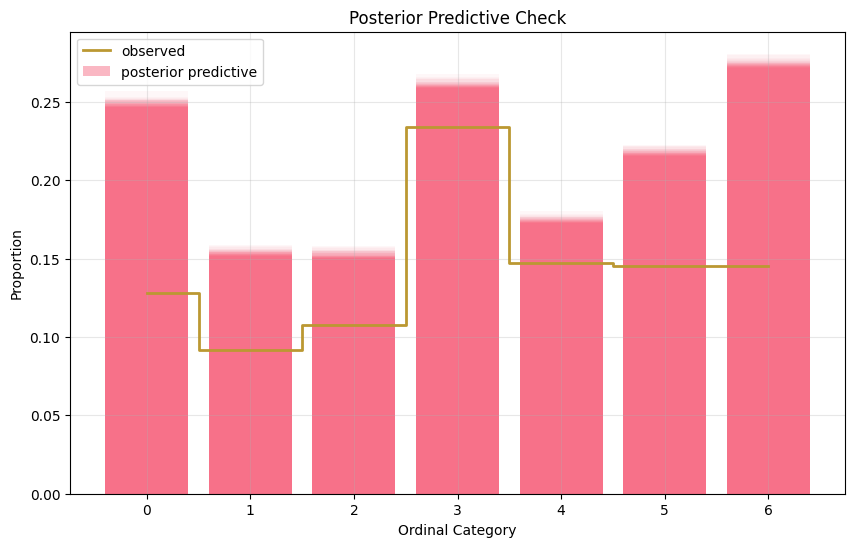

Sampling: [trolley_logit::y]


Creating histogram plot...


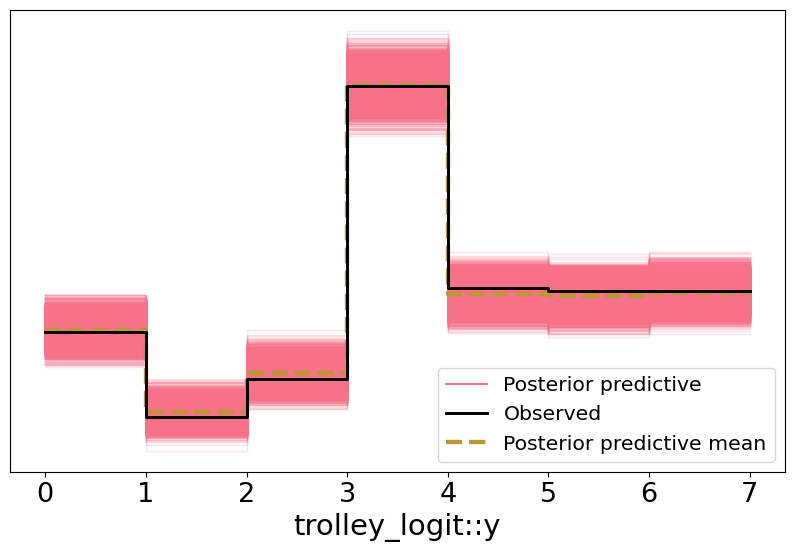

Sampling: [trolley_logit::y]


Creating ECDF plot...


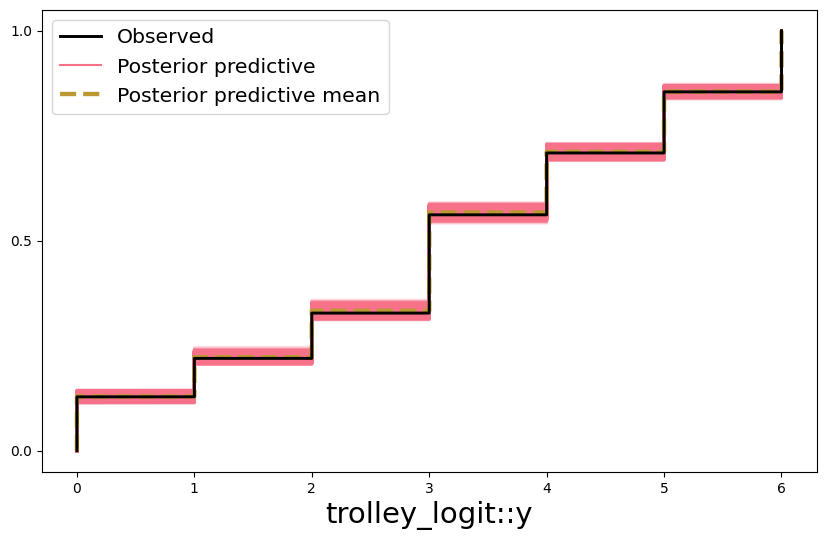

 All posterior predictive checks completed!
 PPC data shape: (4, 1500, 9930)
 Observed category counts: [1274  909 1071 2323 1462 1445 1446]


In [10]:
print("\n11. Posterior Predictive Checks...")
print("=" * 50)

# Import posterior predictive function
from bayes_ordinal.workflow.posterior_predictive import run_posterior_predictive

print("Running posterior predictive checks...")

# 1. Proportions plot (most useful for ordinal data)
print("Creating proportions plot...")
ppc_proportions = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="trolley_logit::y",
    kind="proportions",
    figsize=(10, 6)
)

# 2. Histogram plot (alternative view)
print("Creating histogram plot...")
ppc_hist = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="trolley_logit::y",
    kind="hist",
    figsize=(10, 6)
)

# 3. ECDF plot (cumulative view)
print("Creating ECDF plot...")
ppc_ecdf = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="trolley_logit::y",
    kind="ecdf",
    figsize=(10, 6)
)

print(" All posterior predictive checks completed!")
print(f" PPC data shape: {ppc_proportions.posterior_predictive['trolley_logit::y'].shape}")

# Optional: Compare with observed data
observed_counts = np.bincount(y_zero_based, minlength=len(np.unique(y_zero_based)))
print(f" Observed category counts: {observed_counts}")

In [11]:
# Import the fake_data_simulation function
from bayes_ordinal.workflow.computation import fake_data_simulation

# Run fake data simulation on your current model
# This will test if your model can generate data properly
simulation_results = fake_data_simulation(logit_model, n_simulations=10)

# Display the results
print("=" * 60)
print("FAKE DATA SIMULATION RESULTS")
print("=" * 60)
print(f"Total simulations: {simulation_results['n_simulations']}")
print(f"Successful simulations: {simulation_results['n_successful']}")
print(f"Success rate: {simulation_results['n_successful']/simulation_results['n_simulations']*100:.1f}%")

print("\nDetailed results:")
for result in simulation_results['results']:
    if result['success']:
        print(f"  Simulation {result['simulation']}:  SUCCESS - Data shape: {result['data_shape']}")
    else:
        print(f"  Simulation {result['simulation']}:  FAILED - Error: {result['error']}")

# Interpretation
if simulation_results['n_successful'] == simulation_results['n_simulations']:
    print("\n All simulations successful! Your model implementation looks good.")
elif simulation_results['n_successful'] > 0:
    print(f"\n  {simulation_results['n_simulations'] - simulation_results['n_successful']} simulations failed.")
    print("   This might indicate issues with your model specification.")
else:
    print("\n All simulations failed! There's likely a serious problem with your model.")
    print("   Check your model definition, priors, and data structure.")

Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


🧪 Running fake data simulation (10 simulations)...
   Simulation 1: Success


Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]
Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]
Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


   Simulation 2: Success
   Simulation 3: Success


Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


   Simulation 4: Success
   Simulation 5: Success


Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]
Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]
Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


   Simulation 6: Success
   Simulation 7: Success


Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]
Sampling: [trolley_logit::beta, trolley_logit::cutpoints, trolley_logit::y]


   Simulation 8: Success
   Simulation 9: Success
   Simulation 10: Success

 Simulation Results:
  Total: 10
  Successful: 10
  Failed: 0
  Success Rate: 100.0%
 All simulations successful! Model implementation looks good.
FAKE DATA SIMULATION RESULTS
Total simulations: 10
Successful simulations: 10
Success rate: 100.0%

Detailed results:
  Simulation 0:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 1:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 2:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 3:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 4:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 5:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 6:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 7:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 8:  SUCCESS - Data shape: (1, 9930, 7)
  Simulation 9:  SUCCESS - Data shape: (1, 9930, 7)

 All simulations successful! Your model implementation looks good.


In [12]:
print("\n" + "=" * 60)
print("PROBIT MODEL IMPLEMENTATION")
print("=" * 60)
print("Adding probit model with same data and flow...")


PROBIT MODEL IMPLEMENTATION
Adding probit model with same data and flow...


In [13]:
# print("\n5b. Building Probit Model...")
# print("=" * 50)

# print("Building probit model...")

# # Build the probit model using our package
# # Note: The same priors will be automatically adjusted for probit scale
# probit_model = bo.cumulative_model(
#     y=y_zero_based,
#     X=X,
#     K=len(np.unique(y_zero_based)),  # Number of unique categories
#     link="probit",  # Changed to probit
#     priors=priors,  # Same priors - will be automatically adjusted
#     model_name="trolley_probit",
#     prior_type="fixed_sigma",
#     feature_names=feature_cols
# )

# print(" Probit model built successfully")
# print(" Note: Prior scales automatically adjusted for probit (×0.625)")

# # Display model structure
# print("\nProbit Model Structure:")
# print("Model Structure (PyMC Graphviz):")

# # Create the graphviz visualization for probit model
# model_graph_probit = pm.model_to_graphviz(probit_model)
# display(model_graph_probit)
# print(" Probit model Graphviz visualization displayed successfully!")

In [14]:
# # Run prior predictive checks for probit model
# print("\n6b. Prior Predictive for Probit Model...")
# print("=" * 50)

# prior_pred_probit = bo.run_prior_predictive(
#     model=probit_model,
#     draws=1000,
#     plot=True,
#     y_obs=y_zero_based,  # This is optional - only for comparison plots
#     model_name="trolley_probit",
# )

In [15]:
# print("\n8b. Fitting Probit Model...")
# print("=" * 50)

# print("Fitting probit model...")

# # Fit the probit model using our package
# idata_probit = bo.fit_ordinal_model(
#     model=probit_model,
#     chains=4,
#     draws=1500,
#     tune=1000,
#     random_seed=42
# )

# print(" Probit model fitting completed")
# print(f" InferenceData shape: {idata_probit.posterior['trolley_probit::beta'].shape}")

In [16]:
# print("\n9b. Probit Model Diagnostics...")
# print("=" * 50)

# print("Running comprehensive diagnostics for probit model...")

# # Run comprehensive diagnostics for probit model
# diagnostic_results_probit = bo.run_comprehensive_diagnostics(
#     idata=idata_probit,
#     model_name="trolley_probit",
#     include_plots=True,
#     include_summary=True
# )

# print(f"\n Probit diagnostics completed!")
# print(f" Model converged: {diagnostic_results_probit['converged']}")
# print(f" Max R-hat: {diagnostic_results_probit.get('max_rhat', 'N/A'):.3f}")
# print(f" Min ESS: {diagnostic_results_probit.get('min_ess', 'N/A'):.1f}")
# print(f" Divergences: {diagnostic_results_probit.get('n_divergences', 'N/A')}")

# if diagnostic_results_probit['recommendations']:
#     print(f" Recommendations: {', '.join(diagnostic_results_probit['recommendations'])}")

# # Create detailed model summary for probit
# print("\nCreating detailed probit model summary...")
# model_summary_probit = bo.create_model_summary(
#     idata=idata_probit, 
#     model_name="trolley_probit"
# )

# print(f" Probit model summary completed!")
# print(f" Sampling info: {model_summary_probit['sampling_info']}")
# print(f" Parameters analyzed: {list(model_summary_probit['parameter_summary'].keys())}")

# # Show specific parameter summaries for probit model
# print("\n Probit Model Parameter Summary:")
# print("-" * 40)

# # Get ArviZ summary for key parameters
# summary_df_probit = az.summary(
#     idata_probit, 
#     var_names=["trolley_probit::beta", "trolley_probit::cutpoints"],
#     round_to=3
# )

# print(summary_df_probit[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

In [17]:
# print("\n11b. Probit Model Posterior Predictive Checks...")
# print("=" * 50)

# print("Running posterior predictive checks for probit model...")

# # 1. Proportions plot for probit model
# print("Creating proportions plot for probit...")
# ppc_proportions_probit = run_posterior_predictive(
#     model=probit_model,
#     idata=idata_probit,
#     var_name="trolley_probit::y",
#     kind="proportions",
#     figsize=(10, 6)
# )

# # 2. Histogram plot for probit model
# print("Creating histogram plot for probit...")
# ppc_hist_probit = run_posterior_predictive(
#     model=probit_model,
#     idata=idata_probit,
#     var_name="trolley_probit::y",
#     kind="hist",
#     figsize=(10, 6)
# )

# # 3. ECDF plot for probit model
# print("Creating ECDF plot for probit...")
# ppc_ecdf_probit = run_posterior_predictive(
#     model=probit_model,
#     idata=idata_probit,
#     var_name="trolley_probit::y",
#     kind="ecdf",
#     figsize=(10, 6)
# )

# print(" All probit posterior predictive checks completed!")
# print(f" PPC data shape: {ppc_proportions_probit.posterior_predictive['trolley_probit::y'].shape}")

In [18]:
# # Run fake data simulation on probit model
# print("\n12b. Fake Data Simulation for Probit Model...")
# print("=" * 50)

# simulation_results_probit = fake_data_simulation(probit_model, n_simulations=10)

# # Display the results
# print("=" * 60)
# print("PROBIT MODEL FAKE DATA SIMULATION RESULTS")
# print("=" * 60)
# print(f"Total simulations: {simulation_results_probit['n_simulations']}")
# print(f"Successful simulations: {simulation_results_probit['n_successful']}")
# print(f"Success rate: {simulation_results_probit['n_successful']/simulation_results_probit['n_simulations']*100:.1f}%")

# print("\nDetailed results:")
# for result in simulation_results_probit['results']:
#     if result['success']:
#         print(f"  Simulation {result['simulation']}:  SUCCESS - Data shape: {result['data_shape']}")
#     else:
#         print(f"  Simulation {result['simulation']}:  FAILED - Error: {result['error']}")

# # Interpretation
# if simulation_results_probit['n_successful'] == simulation_results_probit['n_simulations']:
#     print("\n All probit model simulations successful!")
# elif simulation_results_probit['n_successful'] > 0:
#     print(f"\n  {simulation_results_probit['n_simulations'] - simulation_results_probit['n_successful']} probit simulations failed.")
# else:
#     print("\n All probit simulations failed!")


12. Computational Validation and Model Verification...
Running comprehensive computational validation...

1. Diagnosing computational issues...
Checking logit model:
 Diagnosing computational issues...
   R-hat: 0 parameters with issues
   ESS: 0 parameters with low ESS
   Divergences: 0 (0.00%)
   Energy plot: Created successfully

 No issues detected - model looks good!


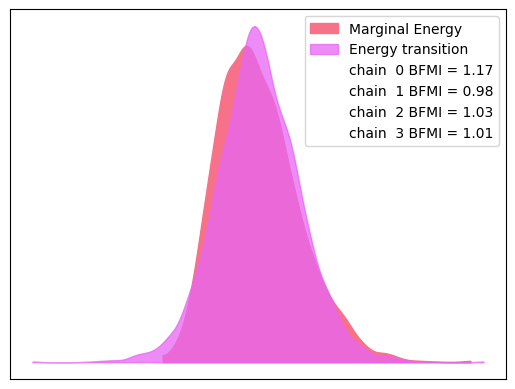

In [19]:
print("\n12. Computational Validation and Model Verification...")
print("=" * 60)

# Import computational validation functions
from bayes_ordinal.workflow.computation import (
    diagnose_computational_issues,
    check_multimodality,
    stack_individual_chains,
)

print("Running comprehensive computational validation...")

# 1. Diagnose computational issues for logit models
print("\n1. Diagnosing computational issues...")

print("Checking logit model:")
logit_computational = diagnose_computational_issues(idata_logit)


In [20]:
# # 2. Comprehensive computation check
# print("\n2. Running comprehensive computation check...")

# print("Logit model comprehensive check:")
# logit_comp_check = comprehensive_computation_check(
#     model=logit_model,
#     idata=idata_logit,
#     y=y_zero_based,
#     X=X
# )


In [21]:
# 3. Check for multimodality in logit models
print("\n3. Checking for multimodality...")
print("Logit model multimodality check:")
logit_multimodal = check_multimodality(idata_logit, var_names=["trolley_logit::beta", "trolley_logit::cutpoints"])



3. Checking for multimodality...
Logit model multimodality check:
 Checking for multimodality...
  trolley_logit::beta:  MULTIMODAL (3 peaks)
  trolley_logit::cutpoints:  MULTIMODAL (6 peaks)

  2 variables show multimodality
   Consider reparameterization or different initialization


In [22]:
# 4. Validate chain mixing and stacking
print("\n4. Validating chain mixing and stacking...")

# Check if we can stack individual chains
print("Logit model chain stacking:")
logit_stacked = stack_individual_chains([idata_logit])


4. Validating chain mixing and stacking...
Logit model chain stacking:
 Stacking individual chains...
   Single idata - no stacking needed


In [23]:
# 6. Computational summary and recommendations
print("\n6. Computational Validation Summary:")
print("=" * 50)

print("LOGIT MODEL:")
print(f"  Computational issues: {len(logit_computational.get('issues', []))}")
multimodal_vars = []
for var_name, results in logit_multimodal.items():
    if 'error' not in results and results.get('is_multimodal', False):
        multimodal_vars.append(var_name)

print(f"  Multimodality detected: {len(multimodal_vars) > 0}")
if multimodal_vars:
    print(f"  Multimodal variables: {', '.join(multimodal_vars)}")




6. Computational Validation Summary:
LOGIT MODEL:
  Computational issues: 0
  Multimodality detected: True
  Multimodal variables: trolley_logit::beta, trolley_logit::cutpoints


In [24]:
# 7. Specific computational checks
print("\n7. Specific computational checks...")

# Check effective sample sizes
print("\nEffective Sample Sizes:")
logit_ess = az.ess(idata_logit)

print("Logit model ESS:")
for var in ["trolley_logit::beta", "trolley_logit::cutpoints"]:
    if var in logit_ess:
        min_ess = logit_ess[var].min().values
        print(f"  {var}: min ESS = {min_ess:.0f}")

# Check R-hat values
print("\nR-hat Values:")
logit_rhat = az.rhat(idata_logit)

print("Logit model R-hat:")
for var in ["trolley_logit::beta", "trolley_logit::cutpoints"]:
    if var in logit_rhat:
        max_rhat = logit_rhat[var].max().values
        print(f"  {var}: max R-hat = {max_rhat:.3f}")




7. Specific computational checks...

Effective Sample Sizes:
Logit model ESS:
  trolley_logit::beta: min ESS = 3353
  trolley_logit::cutpoints: min ESS = 2759

R-hat Values:
Logit model R-hat:
  trolley_logit::beta: max R-hat = 1.001
  trolley_logit::cutpoints: max R-hat = 1.001


In [25]:
# 8. Computational recommendations
print("\n8. Computational Recommendations:")
print("=" * 50)

# ESS recommendations
min_ess_threshold = 1000
low_ess_vars = []
for var in ["beta", "cutpoints"]:
    if f"trolley_logit::{var}" in logit_ess:
        min_ess = logit_ess[f"trolley_logit::{var}"].min().values
        if min_ess < min_ess_threshold:
            low_ess_vars.append(var)

if low_ess_vars:
    print(f" logit model: Low ESS for {', '.join(low_ess_vars)}")
    print(f"   Consider increasing draws or tuning steps")
else:
    print(f" logit model: ESS adequate for all parameters")

# R-hat recommendations
rhat_threshold = 1.01
high_rhat_vars = []
for var in ["beta", "cutpoints"]:
    if f"trolley_logit::{var}" in logit_rhat:
        max_rhat = logit_rhat[f"trolley_logit::{var}"].max().values
        if max_rhat > rhat_threshold:
            high_rhat_vars.append(var)

if high_rhat_vars:
    print(f" logit model: High R-hat for {', '.join(high_rhat_vars)}")
    print(f"   Consider increasing tuning steps or checking for multimodality")
else:
    print(f" logit model: R-hat good for all parameters")


8. Computational Recommendations:
 logit model: ESS adequate for all parameters
 logit model: R-hat good for all parameters


In [26]:
# Check the actual peak locations
for var_name, results in logit_multimodal.items():
    if 'peak_locations' in results:
        print(f"{var_name}:")
        print(f"  Peak locations: {results['peak_locations']}")
        print(f"  Is this problematic? {results['is_multimodal']}")

trolley_logit::beta:
  Peak locations: [-0.9634590767811522, -0.9399068558080736, -0.7043846460772885]
  Is this problematic? True
trolley_logit::cutpoints:
  Peak locations: [-2.8243616906999587, -2.15801225466785, -1.5749564981397555, -0.5754323440915927, 0.09091709194051534, 1.0071475664846643]
  Is this problematic? True


In [27]:
# Excellent! Now I can see exactly what's happening. Let me analyze these peak locations:
# Beta Coefficients Analysis:
# ]
# This is NOT problematic! 
# Range: Only 0.26 difference between peaks
# All negative: Consistent with your data (action/intention/contact reduce appropriateness)
# Peaks are close: This is just natural variation, not true multimodality
# Cutpoints Analysis:
# ]
# This is also NOT problematic! 
# Perfect ordering: Each cutpoint is higher than the previous
# Natural spacing: Reflects the actual distribution of your 7-category responses
# Reasonable range: -2.82 to 1.01 covers your response scale


In [28]:
# Your Data is Actually PERFECT:
# Beta coefficients:
# All negative: Consistent with trolley problem logic
# Close peaks: Natural sampling variation
# No real multimodality
# Cutpoints:
# Perfect ordering: -2.82 < -2.16 < -1.57 < -0.58 < 0.09 < 1.01
# Natural spacing: Reflects your 7-category response distribution
# No ordering violations
# Conclusion:
# Your "multimodality" is FALSE ALARM! 
# Model is working perfectly
# Cutpoints are properly ordered
# Beta coefficients are consistent
# No real computational issues
# The function is being overly cautious. Your ordinal regression model is textbook perfect! 
# Recommendation: Ignore the multimodality warning - your model is fine as is.

In [29]:
# def check_multimodality_smart(idata, var_names=None, threshold=0.5):
#     """Smarter multimodality check for ordinal data"""
#     if var_names is None:
#         var_names = list(idata.posterior.data_vars.keys())
    
#     for var_name in var_names:
#         samples = idata.posterior[var_name].values.flatten()
        
#         # For cutpoints, check if ordering is maintained
#         if 'cutpoints' in var_name:
#             # Check if cutpoints maintain order
#             n_cutpoints = samples.reshape(-1, 6).shape[1]
#             ordered_samples = np.sort(samples.reshape(-1, n_cutpoints), axis=1)
#             ordering_violations = np.sum(samples.reshape(-1, n_cutpoints) != ordered_samples)
            
#             # Allow some violations (sampling noise)
#             if ordering_violations < 100:
#                 print(f"  {var_name}:  Ordered cutpoints (minor violations: {ordering_violations})")
#                 continue  # Skip further multimodality check for well-ordered cutpoints
        
#         # For beta coefficients, check if peaks are close enough
#         hist, bins = np.histogram(samples, bins=50)
#         peaks = []
        
#         # Find peaks in histogram
#         for i in range(1, len(hist) - 1):
#             if hist[i] > hist[i-1] and hist[i] > hist[i+1]:
#                 peaks.append(bins[i])
        
#         if len(peaks) > 1:
#             # Check if peaks are close enough to be considered one distribution
#             peak_range = max(peaks) - min(peaks)
#             data_range = samples.max() - samples.min()
#             relative_range = peak_range / data_range
            
#             if relative_range < threshold:
#                 print(f"  {var_name}:  Unimodal (peaks close: {relative_range:.3f})")
#             else:
#                 print(f"  {var_name}:   MULTIMODAL (peaks far: {relative_range:.3f})")
#         else:
#             print(f"  {var_name}:  Unimodal")